## XAI 1: Introduction to Saliency Maps with Captum

Base example based on:

*   https://captum.ai/tutorials/TorchVision_Interpret
*   https://pytorch.org/tutorials/beginner/introyt/captumyt.html

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

!pip install captum
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.6 MB/s eta 0:00:00


/Users/axelsorensen/miniconda3/envs/responsible_ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's start out with a pretrained ResNet

In [2]:
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.eval()

In [ ]:
#model

Let's fetch the imagenet labels for interpretation of model, as well as an image to test on

In [12]:
!mkdir -p $HOME/.torch/models && curl -o $HOME/.torch/models/imagenet_class_index.json https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35363  100 35363    0     0  63374      0 --:--:-- --:--:-- --:--:-- 63261


In [14]:
# Imagenet labels


labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Let's implement the ImageNet transforms

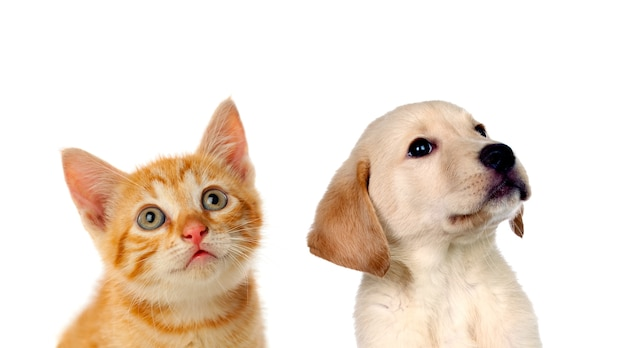

In [15]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

response = requests.get("https://image.freepik.com/free-photo/two-beautiful-puppies-cat-dog_58409-6024.jpg")
img = Image.open(BytesIO(response.content))

display(img)

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Let's predict the class of the image

In [16]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: Labrador_retriever ( 0.08576233685016632 )


## Let's take a look at the Integrated Gradients saliency map

In [17]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

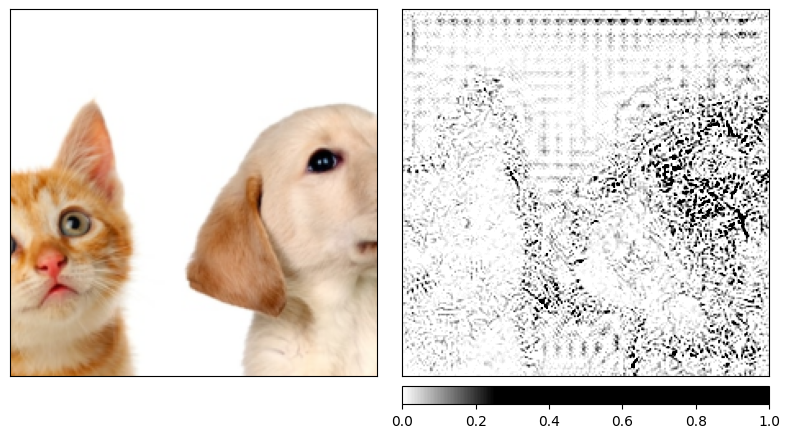

In [18]:
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             cmap=default_cmap,
                             show_colorbar=True,
                             signs=["all", "positive"],
                             outlier_perc=1)


Next, we apply the same smoothing trick as in SmoothGrad -- in Captum, this is called a *noise tunnel*, and can be applied to any saliency map

In [19]:
from captum.attr import NoiseTunnel

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

KeyboardInterrupt: 

## Next, we add the GradCam saliency map

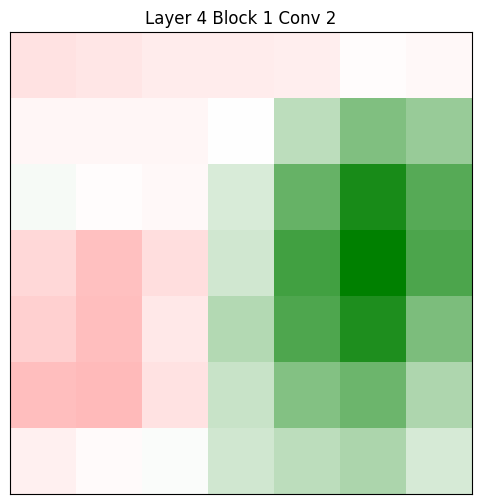

In [20]:
layer_gradcam = LayerGradCam(model, model.layer4[1].conv2)
attributions_lgc = layer_gradcam.attribute(input, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 4 Block 1 Conv 2")

Upsample GradCam saliency map to original image domain

torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


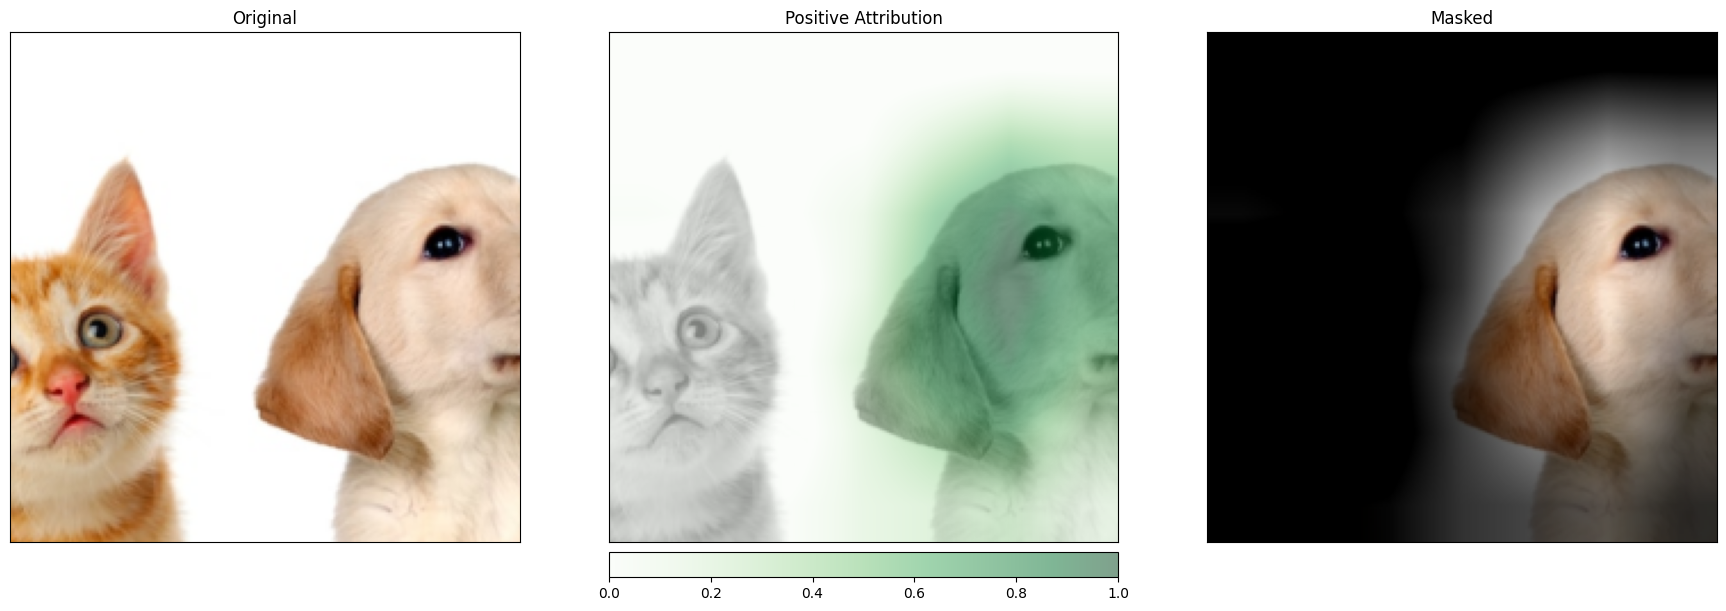

In [21]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input.shape[2:], 'bilinear')

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

# Exercise!
Pick among the following exercises, and make sure that you get well acquainted with the different types of saliency maps

1.   Try out different saliency methods implemented in Captum -- do they tell the same story? Try also with your own test images. Also check out some that we didn't discuss -- how do they differ from the ones we have gone through in class?
2.   In the Colab Notebook on shortcut learning, try to insert a synthetic shortcut in the simple MNIST classifier by retraining it on data that is corrupted, e.g. by adding a number of consequtive white pixels that corresponds to the ground truth integer. Can you get the model to learn a shortcut? Can you detect it using saliency maps?
3.   Can you reproduce the example where saliency maps are left untouched by adversarial attacks? Check out e.g. the torchattacks *toolbox*

